In [21]:
from __future__ import division
import numpy as np
import os

from PIL import Image

from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from torchvision import transforms, datasets

from matplotlib import pyplot as plt
import matplotlib
import random
%matplotlib inline
import hiddenlayer as hl

from dataset.dataset import * 
from models.models import *
from util.util import *

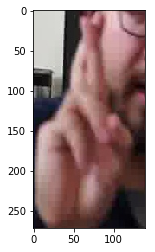

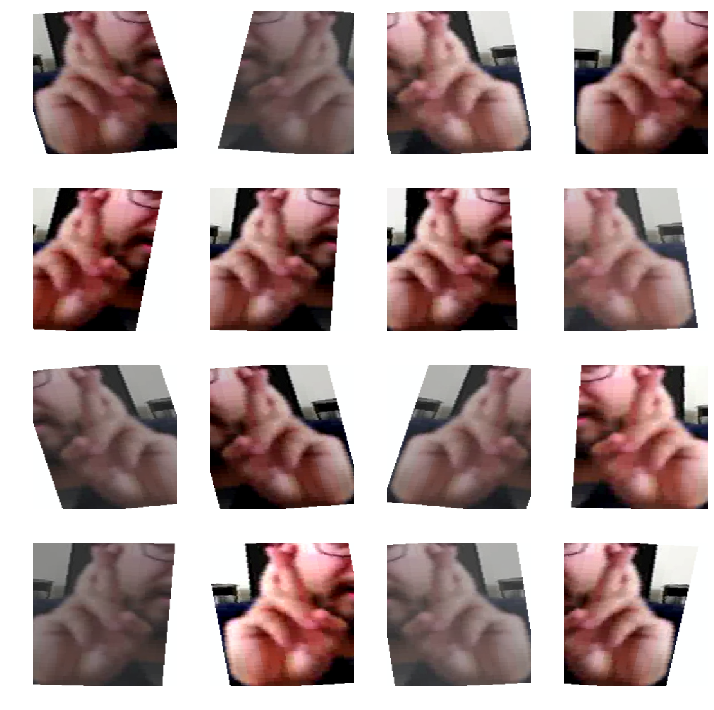

In [42]:
#Show transforms of a single image
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

test_img_folder = 'balanced/'
r = random.choice(os.listdir(test_img_folder)) #change dir name to whatever
img_path = test_img_folder + r

ex_img = Image.open(img_path)

plt.imshow(ex_img)

transforms = get_image_transforms()
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(transforms['train'](ex_img), ax=ax)

plt.tight_layout()

In [43]:
#Create datasets

img_dataset_path = 'balanced/'
partition = {'train':[], 'validation':[], 'test':[]}
labels = {}
classes = list('ABCDEFHIKLMNOPQRTUVWY')

files = os.listdir(img_dataset_path)
random.shuffle(files)

c = 0
N = len(files)

for name in files:
    #70% train
    #15% valid
    #15% test
    if(c>=N*0.3):
        partition['train'].append(name)
    if(c<N*0.15):
        if(c<=N*0.15):
            partition['validation'].append(name)
        else:
            partition['test'].append(name)
    labels[name] = classes.index(name[0])
    c = c + 1

# Parameters
params = {'batch_size': 64, 'shuffle' : True}

# Generators
training_set = Signs_Dataset(partition['train'], labels, 
                             img_path = img_dataset_path, transform=transforms['train'])
validation_set = Signs_Dataset(partition['validation'], labels, 
                               img_path = img_dataset_path, transform=transforms['valid'])
test_set = Signs_Dataset(partition['test'], labels,
                         img_path = img_dataset_path, transform=transforms['valid'])

#Dataloaders
sign_loader_train = data.DataLoader(training_set, **params)
sign_loader_validation = data.DataLoader(validation_set, **params)
sign_loader_test = data.DataLoader(test_set, **params)

print("Dataloaders done")

Dataloaders done


In [57]:
#Model selection
#model = LeNet5(n_output=21) 
model = AlexNet(n_output=21)
print(model)
loss = torch.nn.CrossEntropyLoss()
use_gpu = True
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
if use_gpu:
    model = model.cuda()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Lin

In [ ]:
#Training process

def train(epochs, train_loader, valid_loader):
    h = hl.History()
    c = hl.Canvas()

    for epoch in range(epochs):
        # Training
        train_loss = 0.0
        for image_batch, label_batch in train_loader:
            optimizer.zero_grad()
            if use_gpu:
                image_batch = image_batch.cuda()
                label_batch = label_batch.cuda()
            predictions = model.forward(image_batch)
            loss_batch = loss(predictions, label_batch)        
            loss_batch.backward()
            optimizer.step()
            train_loss += loss_batch.detach().cpu()/train_loader.__len__()
        h.log(epoch, train_loss=train_loss)

        # Validation
        validation_loss = 0.0
        for image_batch, label_batch in valid_loader:
            if use_gpu:
                image_batch = image_batch.cuda()
                label_batch = label_batch.cuda()
            predictions = model.forward(image_batch)
            loss_batch = loss(predictions, label_batch)    
            validation_loss += loss_batch.detach().cpu()/valid_loader.__len__()
        h.log(epoch, validation_loss=validation_loss)
        with c:
            c.draw_plot([h["train_loss"], h["validation_loss"]],["Train loss", "Validation loss"])
        print("Epoch %d, T loss %0.4f, V loss %0.4f" %(epoch, train_loss, validation_loss))

epochs = 10
train(epochs, sign_loader_train, sign_loader_validation)

In [55]:
#Save weights
results_path = "results"
experiment_name = "/alphabet_alexnet" + str(epochs)

weights_file_path     = results_path + experiment_name + experiment_name + ".weights"
c_matrix_file_path    = results_path + experiment_name + experiment_name + ".png"

if not os.path.exists(results_path + experiment_name):
    os.makedirs(results_path + experiment_name)
model.save_weights(weights_file_path)

In [45]:
#Load weights when kernel deads
epochs = 1
results_path = "results"
experiment_name = "/alphabet_alexnet" + str(epochs)

weights_file_path     = results_path + experiment_name + experiment_name + ".weights"
c_matrix_file_path    = results_path + experiment_name + experiment_name + ".png"

model.load_weights(weights_file_path)

In [53]:
#Generate confusion matrix

def generate_confussion_matrix():
    predictions_test = []
    label_test = []
    for i, (image_batch, label_batch) in enumerate(sign_loader_test):
        if use_gpu:
            image_batch = image_batch.cuda()
            label_batch = label_batch.cuda()
        label_test.append(label_batch.detach().cpu().numpy())
        img_example = model.forward(image_batch)
        predictions_test.append(torch.softmax(img_example, dim=1).detach().cpu().numpy())

    predictions_test = np.concatenate(predictions_test, axis = 0)
    label_test = np.concatenate(label_test, axis = 0)

    import itertools
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(label_test, np.argmax(predictions_test, axis = 1))
    cm = cm/np.sum(cm, axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(len(classes))); 
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    ax.set_ylabel('True label'); ax.set_xlabel('Predicted label')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.savefig(c_matrix_file_path, dpi=fig.dpi)

generate_confussion_matrix() 

ValueError: need at least one array to concatenate

torch.Size([1, 256, 26, 26])
256


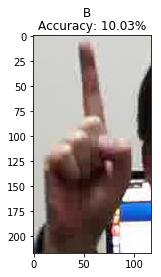

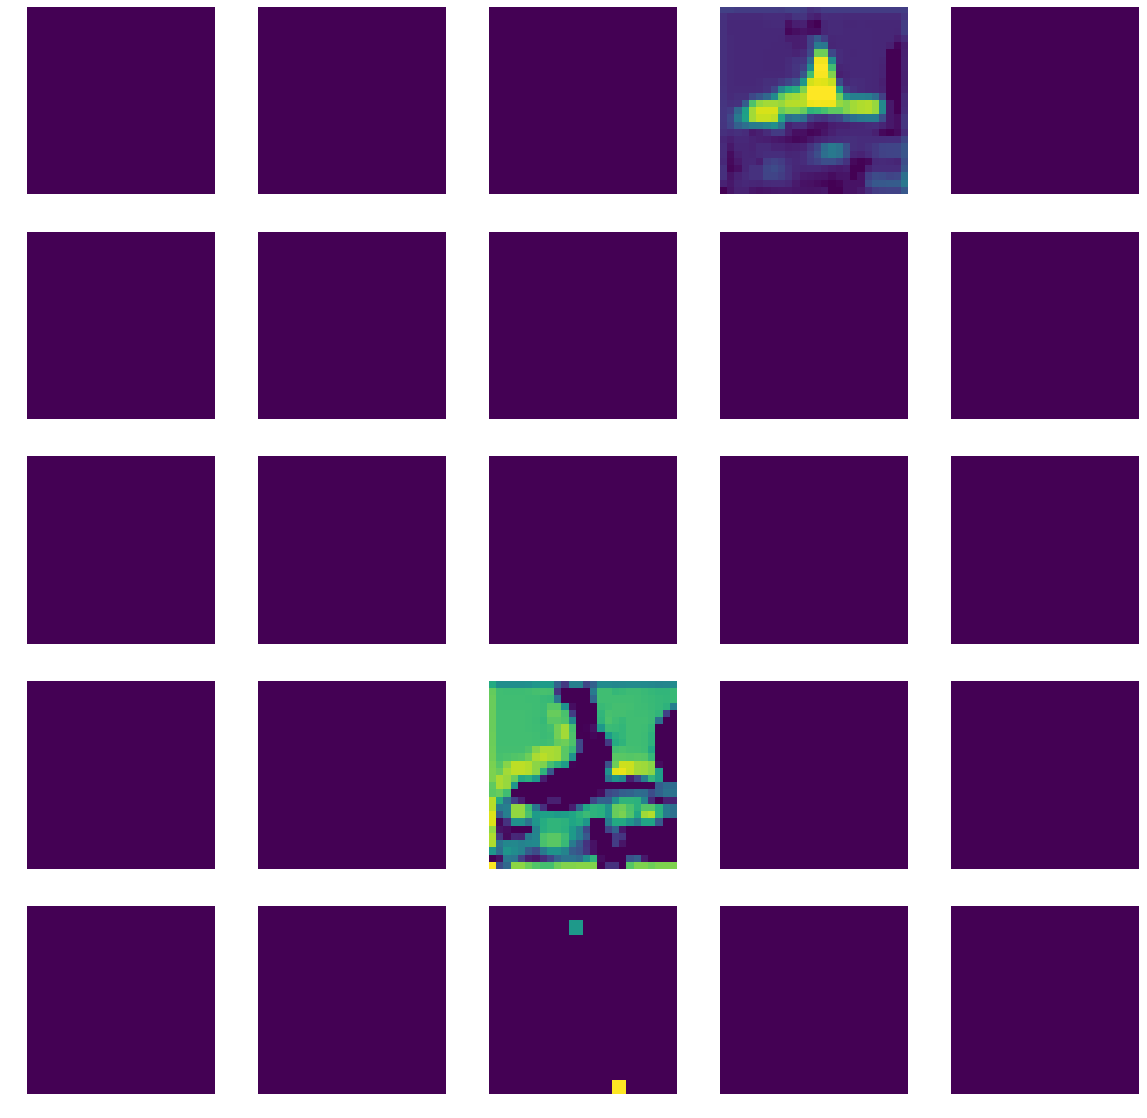

In [51]:
#Choose an image of the folder and show the class
#If img_name = '' then choose a random image
test_img_folder = 'balanced/'
#test_img_path = 'american/'

#test_image_from_path(model, test_img_path, img_name, use_gpu, transform):
test_image_from_path(model, test_img_folder, '', True, transforms['valid'])

In [52]:
#Choose an random image of the test dataset and show the class

#test_image_from_dataset(model, use_gpu, transform, dataset)
test_image_from_dataset(model, True, transforms['valid'], partition['test'])

IndexError: list index out of range